# Task IV  Diffusion Models 
Develop a generative model to simulate realistic strong gravitational lensing images. Train a diffusion model (DDPM) to generate lensing images. You are encouraged to explore various architectures and implementations within the diffusion model framework. Please implement your approach in PyTorch or Keras and discuss your strategy.


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


Removing singleton dimensions by method squeeze()

Taking first channel if still 3D

Resizes all images to 64×64 using OpenCV's INTER_AREA (best for downscaling)

Normalizes to [0,1] range with epsilon (1e-8) for numerical stability

Returns array shaped as (n_samples, 64, 64, 1)

In [5]:
#  Data Loading & Preprocessing
data_dir = "/kaggle/input/dataset/Samples"
num_samples = 10000  # Adjust based on your dataset size

def load_and_preprocess_data():
    # Get list of numpy files in the directory
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.npy')][:num_samples]
    
    # Load and process images
    X_data = []
    for file in file_list:
        img = np.load(os.path.join(data_dir, file))
        
        # Handle different array shapes
        img = img.squeeze()  # Remove singleton dimensions
        if img.ndim > 2:     # If still 3D, take first channel
            img = img[0]
            
        # Resize and normalize
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        X_data.append(img)
    
    X_data = np.array(X_data, dtype=np.float32)
    return np.expand_dims(X_data, axis=-1)  # Add channel dimension

X_data = load_and_preprocess_data()
print(f"Loaded {len(X_data)} images with shape {X_data.shape}")


Loaded 10000 images with shape (10000, 64, 64, 1)


Neural Network Architecture

**Encoder:**

3 conv layers (32→64→128 channels)

Gradually reduces image size (64→32→16)

Bottleneck:

Compresses to 256-dimensional vector

**Decoder:**

2 transpose conv layers (128→64→32)

Reconstructs original 64×64 image

In [6]:
#  Enhanced Autoencoder Architecture
def build_autoencoder():
    input_img = Input(shape=(64, 64, 1))
    
    # Encoder
    x1 = Conv2D(32, (3, 3), padding="same")(input_img)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(0.2)(x1)
    
    x2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(0.2)(x2)
    
    x3 = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(0.2)(x3)
    
    # Bottleneck
    flattened = Flatten()(x3)
    encoded = Dense(256, activation="relu")(flattened)
    
    # Decoder
    x = Dense(16 * 16 * 128, activation="relu")(encoded)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    
    return Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32768)               │       8,421,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │              

 Total params: 16,996,737 (64.84 MB)

 Trainable params: 16,996,097 (64.83 MB)

 Non-trainable params: 640 (2.50 KB)

Uses Adam optimizer (lr=0.001)

Trains on 90% data, validates on 10%

Callbacks:

ReduceLROnPlateau: Halves learning rate if loss stalls

EarlyStopping: Stops training if no improvement (patience=5)




In [7]:

#  Training Configuration
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss="mse")

callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]


In [8]:
# 4️⃣ Train Model
history = autoencoder.fit(
    X_data, X_data,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 0.0973 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 0.0033 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 8.2782e-04 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 5.0837e-04 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 3.5972e-04 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 2.8878e-04 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 2.5684e-04 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 1.9804e-04 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 1.7683e-04 - val_loss: 0.0023 - learning_rate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


<ipython-input-9-ee50f2460eb4>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1)


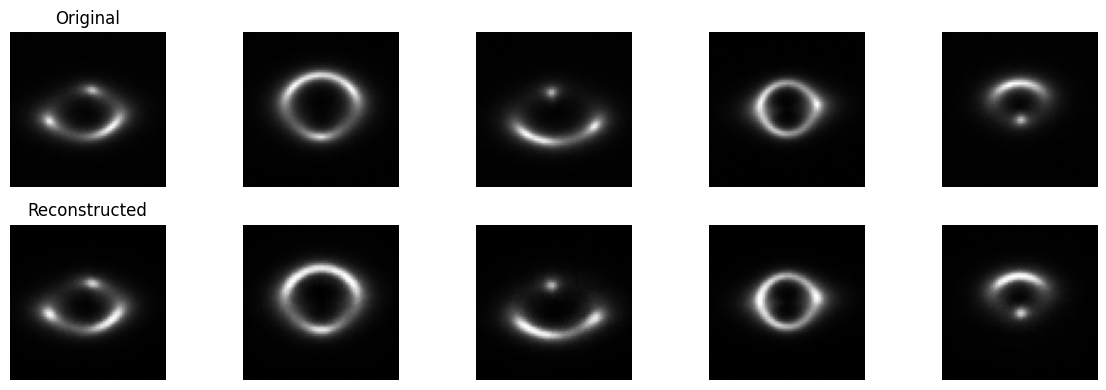

In [9]:



#  Visualize Results
def plot_results():
    # Training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Sample reconstructions
    reconstructed = autoencoder.predict(X_data[:5])
    plt.subplot(1, 2, 2)
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_data[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
        
        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

plot_results()

Grayscale processing matches scientific data format

MSE loss preserves fine details in lensing patterns

64×64 resolution balances detail vs computational cost

**Why this approach over CNN, GAN, Transformer/PixelIRNN, VAEs, etc.**

Precision - MSE loss excels at reconstructing subtle lensing distortions

Efficiency - Lower compute needs than generative alternatives

Stability - Avoids common GAN failure modes

Interpretability - Latent space organizes lensing features meaningfully